# Readme embedding evaluation (315 repostitories / train set)

## 1. Loading repository information

In [1]:
!pip install gdown
!gdown 1sJDBLvVRvl4Sx0ICGuoM27pREIg0M756

Downloading...
From (uriginal): https://drive.google.com/uc?id=1sJDBLvVRvl4Sx0ICGuoM27pREIg0M756
From (redirected): https://drive.google.com/uc?id=1sJDBLvVRvl4Sx0ICGuoM27pREIg0M756&confirm=t&uuid=a203dfd9-959f-45dc-b4fc-0abf2eedfc62
To: /cs/home/hz65/PycharmProjects/RepoSim4Py/Embedding/Embedding_model_train_315/Readme_embedding_evaluation_train_315/repo_info_train.pkl
100%|████████████████████████████████████████| 201M/201M [00:02<00:00, 90.6MB/s]


In [2]:
import pickle

with open("repo_info_train.pkl", "rb") as f:
    repo_info = pickle.load(f)
    f.close()

## 2. Download pre-trained model

In [3]:
!pip3 install torch
!pip3 install transformers
!pip3 install sentence-transformers
!wget https://raw.githubusercontent.com/microsoft/CodeBERT/master/UniXcoder/unixcoder.py
# !curl -O https://raw.githubusercontent.com/microsoft/CodeBERT/master/UniXcoder/unixcoder.py

--2023-07-04 21:45:37--  https://raw.githubusercontent.com/microsoft/CodeBERT/master/UniXcoder/unixcoder.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10352 (10K) [text/plain]
Saving to: ‘unixcoder.py.2’

unixcoder.py.2      100%[===================>]  10.11K  --.-KB/s    in 0s      

2023-07-04 21:45:37 (56.9 MB/s) - ‘unixcoder.py.2’ saved [10352/10352]



In [4]:
import torch

# device = (
#     "cuda"
#     if torch.cuda.is_available()
#     else "mps"
#     if torch.backends.mps.is_available()
#     else "cpu"
# )
device = "cpu"
print(device)

cpu


In [5]:
unixcoder_model_names = [
    "microsoft/unixcoder-base-nine",
    "microsoft/unixcoder-base",
    "microsoft/unixcoder-base-unimodal",
    "Lazyhope/unixcoder-nine-advtest",
    "Lazyhope/unixcoder-clone-detection",
    "Enoch/Unixcoder-Tuned-Code-Search-Py"
]
sentence_transformer_model_names = [
    "sentence-transformers/all-mpnet-base-v2",
    "sentence-transformers/multi-qa-mpnet-base-cos-v1",
    "sentence-transformers/bert-base-nli-mean-tokens",
    "sentence-transformers/paraphrase-multilingual-mpnet-base-v2",
    "sentence-transformers/all-distilroberta-v1",
    "sentence-transformers/distilbert-base-nli-mean-tokens"
]
distil_bert_names = [
    "distilbert-base-uncased"
]

In [6]:
from unixcoder import UniXcoder
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, DistilBertModel

unixcoder_models = {}
sentence_transformer_models = {}
distil_bert_models = {}

# Initialise unixcoder model
for u_name in unixcoder_model_names:
    unixcoder_models[u_name] = UniXcoder(u_name)
    unixcoder_models[u_name].to(device)

# Initialise sentence transformer model
for s_name in sentence_transformer_model_names:
    sentence_transformer_models[s_name] = SentenceTransformer(model_name_or_path=s_name, device=device)

# Initialise DistilBERT model
for d_name in distil_bert_names:
    distil_bert_models[d_name] = {}
    distil_bert_models[d_name]["tokenizer"] = AutoTokenizer.from_pretrained(d_name, device=device)
    distil_bert_models[d_name]["model"] = DistilBertModel.from_pretrained(d_name)

/cs/home/hz65/python/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## 3. Generating readme embeddings

In [7]:
# Getting readme embeddings
def get_unixcoder_embeddings(data, model):
    tokens_ids = model.tokenize([data], max_length=512, mode="<encoder-only>")
    source_ids = torch.tensor(tokens_ids).to(device)
    _, embeddings = model(source_ids)
    return embeddings

# Getting readme embeddings by DistilBERT
def get_bert_embeddings(data, bert_dict):
    tokenizer = bert_dict["tokenizer"]
    model = bert_dict["model"]
    inputs = tokenizer(data, padding=True, truncation=True, max_length=512, return_tensors="pt",)
    outputs = model(**inputs)
    embeddings = torch.mean(outputs.last_hidden_state, dim=1)
    return embeddings

# Getting other embbeddings
def get_other_embeddings(data_list):
    embeddings = {}

    # Unixcoder model
    for u_name, u_model in tqdm(unixcoder_models.items()):
        print(f" - Using {u_name} model - ")
        embeddings_list = torch.concat([get_unixcoder_embeddings(data, u_model) for data in data_list])
        embeddings[u_name] = embeddings_list

    # Sentence transformer model
    for s_name, s_model in tqdm(sentence_transformer_models.items()):
        print(f" - Using {s_name} model - ")
        embeddings_list = s_model.encode(data_list, convert_to_tensor=True)
        embeddings[s_name] = embeddings_list
    
    # Using DistilBERT model
    for d_name, d_dict in tqdm(distil_bert_models.items()):
        print(f" - Using {d_name} model - ")
        embeddings_list = torch.concat([get_bert_embeddings(data, d_dict) for data in data_list])
        embeddings[d_name] = embeddings_list

    return embeddings


# Getting embeddings
def get_embeddings(input_data=None, input_mode=None):
    if input_data is None or not input_data:
        return torch.zeros((768,), device=device)

    with torch.no_grad():
        if input_mode == "readme":
            return get_other_embeddings(input_data)


In [8]:
from tqdm import tqdm

for repo_name, repo_dict in tqdm(repo_info.items()):
    print(f" - Generating readme embeddings for {repo_name} - ")
    repo_dict["readme_embeddings"] = get_embeddings(input_data=repo_dict["readme"], input_mode="readme")

  0%|                                                   | 0/315 [00:00<?, ?it/s]

 - Generating readme embeddings for jet-admin/jet-bridge - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:06,  1.35s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:02<00:04,  1.12s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.01s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:04<00:01,  1.05it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:04<00:00,  1.09it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:05<00:00,  1.03it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.42it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.76it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:00,  2.42it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  2.08it/s]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.07it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



  0%|▏                                          | 1/315 [00:09<47:46,  9.13s/it]

 - Generating readme embeddings for patrys/httmock - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.81it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.39it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.56it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.70it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.74it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.64it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.41it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  8.67it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  8.73it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  1%|▎                                          | 2/315 [00:11<26:06,  5.00s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for pytransitions/transitions - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.55it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  3.49it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  3.58it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  3.51it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  3.56it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.55it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  5.77it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  5.71it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  6.76it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



  1%|▍                                          | 3/315 [00:13<20:38,  3.97s/it]

 - Generating readme embeddings for keleshev/schema - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.18it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.19it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.20it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.18it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  3.97it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.10it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.31it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  7.30it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  7.59it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  1%|▌                                          | 4/315 [00:16<17:19,  3.34s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for dylanaraps/pywal - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.73it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.83it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.78it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.55it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.60it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.65it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  7.05it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  8.91it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.37it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  2%|▋                                          | 5/315 [00:18<14:50,  2.87s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for PyCQA/modernize - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.35it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.47it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.56it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.56it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.60it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.57it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.88it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.17it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.34it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  2%|▊                                          | 6/315 [00:20<13:26,  2.61s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for jaraco/path.py - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.77it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.71it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.74it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.74it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.72it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.70it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.88it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.76it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.92it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  2%|▉                                          | 7/315 [00:22<12:20,  2.41s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for xonsh/xonsh - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.51it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  3.61it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  3.71it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  3.74it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  3.75it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.71it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  1.93it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.34it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  3.15it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.95it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



  3%|█                                          | 8/315 [00:26<14:33,  2.84s/it]

 - Generating readme embeddings for python-excel/xlrd - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  5.02it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.60it/s]


 - Using microsoft/unixcoder-base-unimodal model - 


 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.87it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.89it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.75it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  5.42it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.35it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.50it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  3%|█▏                                         | 9/315 [00:28<13:10,  2.58s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for cloudnativelabs/kube-shell - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.92it/s]

 - Using microsoft/unixcoder-base model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.95it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.85it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.83it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.87it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.01it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.09it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  3%|█▎                                        | 10/315 [00:30<12:13,  2.41s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for ironmussa/Optimus - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.78it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.77it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.81it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.80it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.82it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.80it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.74it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.50it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.26it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  3%|█▍                                        | 11/315 [00:32<11:33,  2.28s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for jazzband/django-taggit - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.73it/s]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.82it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.75it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.81it/s]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  7.12it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.23it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.73it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  4%|█▌                                        | 12/315 [00:34<11:02,  2.19s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for moggers87/salmon - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.85it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  3.92it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  3.96it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  4.00it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.00it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.97it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  2.98it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  4.54it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.41it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



  4%|█▋                                        | 13/315 [00:37<12:16,  2.44s/it]

 - Generating readme embeddings for glamp/bashplotlib - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  2.48it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.52it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.58it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.51it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  2.52it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.53it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.00it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  4.63it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.57it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



  4%|█▊                                        | 14/315 [00:41<14:26,  2.88s/it]

 - Generating readme embeddings for PyCQA/prospector - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.03it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  3.03it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  3.03it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  3.00it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  2.99it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.01it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:07,  1.50s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:03<00:07,  1.89s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.18s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:04<00:01,  1.17it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:05<00:00,  1.08it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



  5%|██                                        | 15/315 [00:48<21:44,  4.35s/it]

 - Generating readme embeddings for twisted/treq - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  2.87it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  3.05it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  3.16it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  3.20it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  3.22it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.18it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.20it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  3.63it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  4.67it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.62it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  6.54it/s]

 - Using distilbert-base-uncased model - 


  5%|██▏                                       | 16/315 [00:52<20:09,  4.05s/it]

 - Generating readme embeddings for bbangert/beaker - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  5.05it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  5.07it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  5.07it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  5.06it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00,  5.06it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  5.06it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  6.31it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  8.32it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  8.99it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  5%|██▎                                       | 17/315 [00:54<16:58,  3.42s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for pypa/bandersnatch - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  2.82it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.77it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.78it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.79it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  2.79it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.78it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  2.08it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.47it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  3.32it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.11it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



  6%|██▍                                       | 18/315 [00:58<18:12,  3.68s/it]

 - Generating readme embeddings for zachwill/moment - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.09it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.49it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.59it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.67it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.70it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.64it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.87it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.04it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.36it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  6%|██▌                                       | 19/315 [01:00<15:43,  3.19s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for encode/apistar - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.90it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  3.82it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  3.79it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  3.77it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  3.78it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.79it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  2.91it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  4.50it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.46it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



  6%|██▋                                       | 20/315 [01:03<15:29,  3.15s/it]

 - Generating readme embeddings for pyinvoke/invoke - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  5.25it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  5.35it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  5.53it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  5.49it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00,  5.65it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  5.61it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  6.92it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00,  9.99it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 10.19it/s]

  7%|██▊                                       | 21/315 [01:05<13:24,  2.74s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for skorokithakis/shortuuid - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.72it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.72it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.72it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.70it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.71it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.71it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  5.75it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  8.97it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.20it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  7%|██▉                                       | 22/315 [01:07<12:21,  2.53s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for s3tools/s3cmd - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.24it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.43it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.55it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.56it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.59it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.54it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.78it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  8.67it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  8.51it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  7%|███                                       | 23/315 [01:09<11:46,  2.42s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for pyenv/pyenv - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  1.92it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.91it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.92it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.92it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  1.92it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:03<00:00,  1.92it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  2.01it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.42it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  3.29it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.02it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



  8%|███▏                                      | 24/315 [01:15<16:07,  3.33s/it]

 - Generating readme embeddings for stchris/untangle - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.79it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.81it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.80it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.81it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.81it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.75it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.98it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.37it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.47it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  8%|███▎                                      | 25/315 [01:17<14:09,  2.93s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for nvdv/vprof - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.90it/s]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.83it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.87it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.85it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.70it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.72it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.76it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  8%|███▍                                      | 26/315 [01:19<12:42,  2.64s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for h2oai/h2o-3 - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:04<00:22,  4.45s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:08<00:17,  4.45s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:13<00:13,  4.44s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:17<00:08,  4.45s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:22<00:04,  4.48s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:26<00:00,  4.47s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:06<00:30,  6.14s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:14<00:30,  7.68s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:16<00:14,  4.92s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:18<00:07,  3.62s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:22<00:03,  3.82s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:23<00:00,  3.86s/it]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



  9%|███▍                                    | 27/315 [02:11<1:24:07, 17.53s/it]

 - Generating readme embeddings for benhamner/Metrics - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  2.28it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.36it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.39it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.40it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  2.40it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.39it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:04,  1.21it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:02<00:04,  1.10s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.43it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.98it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:03<00:00,  1.83it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



  9%|███▌                                    | 28/315 [02:17<1:07:19, 14.08s/it]

 - Generating readme embeddings for jmcarp/robobrowser - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.95it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.92it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.92it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.92it/s]


 - Using Lazyhope/unixcoder-clone-detection model - 


 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.92it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.92it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.86it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.73it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.65it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  9%|███▊                                      | 29/315 [02:19<49:44, 10.44s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for WiserTogether/django-remote-forms - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.88it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.88it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.90it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.90it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.90it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.83it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.25it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.20it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.42it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 10%|████                                      | 30/315 [02:21<37:31,  7.90s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for mahmoud/boltons - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.88it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.81it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.83it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.86it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.87it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.86it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.16it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.16it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.40it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 10%|████▏                                     | 31/315 [02:23<29:02,  6.14s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for stanfordnlp/stanza - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.26it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  3.34it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  3.37it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  3.37it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  3.39it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.38it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.24it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.87it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.90it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 10%|████▎                                     | 32/315 [02:26<24:44,  5.25s/it]

 - Generating readme embeddings for keon/algorithms - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.61it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.61it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.60it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.60it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.41it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.52it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.46it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  8.73it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  8.73it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 10%|████▍                                     | 33/315 [02:28<20:17,  4.32s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for esnme/ultrajson - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  2.71it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.73it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.73it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.73it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  2.73it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.73it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.08it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  4.62it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.68it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 11%|████▌                                     | 34/315 [02:32<19:17,  4.12s/it]

 - Generating readme embeddings for boto/boto3 - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.78it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  3.77it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  3.77it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  3.78it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  3.78it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.77it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  2.92it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  3.46it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.56it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 11%|████▋                                     | 35/315 [02:35<17:43,  3.80s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for geopy/geopy - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.92it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.88it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.86it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.74it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.79it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.81it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.73it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.10it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.38it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 11%|████▊                                     | 36/315 [02:37<15:10,  3.26s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for sdispater/pendulum - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.80it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.75it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.79it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.54it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.63it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.68it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.70it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.22it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.34it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 12%|████▉                                     | 37/315 [02:39<13:24,  2.89s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for omab/python-social-auth - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.37it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.44it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.47it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.33it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.40it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.40it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.24it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  5.66it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  5.63it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 12%|█████                                     | 38/315 [02:41<12:53,  2.79s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for django-guardian/django-guardian - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.63it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.70it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.76it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.76it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.72it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.74it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.51it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.44it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.43it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 12%|█████▏                                    | 39/315 [02:43<11:45,  2.56s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for mongodb/motor - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.28it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.61it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.71it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.61it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.70it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.68it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.12it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.19it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  8.95it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 13%|█████▎                                    | 40/315 [02:45<11:02,  2.41s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for napalm-automation/napalm - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.70it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.65it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.70it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.62it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.68it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.66it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.48it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.33it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.19it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 13%|█████▍                                    | 41/315 [02:47<10:30,  2.30s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for django-crispy-forms/django-crispy-forms - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.80it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.75it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.80it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.78it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.80it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.56it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.37it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.30it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.28it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 13%|█████▌                                    | 42/315 [02:50<10:10,  2.24s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for mymarilyn/clickhouse-driver - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.77it/s]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.73it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.74it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.74it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.74it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.75it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.40it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.56it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 14%|█████▋                                    | 43/315 [02:52<09:49,  2.17s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for sdispater/orator - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.67it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.59it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.55it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.58it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.56it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.56it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.55it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  8.26it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  8.59it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 14%|█████▊                                    | 44/315 [02:54<09:44,  2.16s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for codelucas/newspaper - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.45it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  3.39it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  3.38it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  3.38it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  3.35it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.36it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.03it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  4.56it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.52it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 14%|██████                                    | 45/315 [02:57<11:11,  2.49s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for coleifer/huey - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.54it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  3.58it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  3.58it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  3.62it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  3.64it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.63it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.24it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  3.51it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.51it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 15%|██████▏                                   | 46/315 [03:00<12:00,  2.68s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for sympy/sympy - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.66it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.65it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.65it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.65it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.64it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:03<00:00,  1.64it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:05,  1.05s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:02<00:05,  1.36s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.17it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.61it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:04<00:00,  1.47it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 15%|██████▎                                   | 47/315 [03:08<19:08,  4.29s/it]

 - Generating readme embeddings for gabrielfalcao/HTTPretty - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.86it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.89it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.87it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.89it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.89it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.88it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.90it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.13it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.59it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 15%|██████▍                                   | 48/315 [03:10<15:58,  3.59s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for elapouya/python-docx-template - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  6.51it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  6.47it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  6.41it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  6.34it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00,  6.31it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  6.34it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  6.01it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  5.65it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 10.04it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 10.48it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 


 16%|██████▌                                   | 49/315 [03:12<13:17,  3.00s/it]

 - Generating readme embeddings for dahlia/wand - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.88it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.86it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.88it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.88it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.89it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.88it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.75it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.25it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.66it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 16%|██████▋                                   | 50/315 [03:14<11:51,  2.68s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for mpdavis/python-jose - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.82it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.82it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.84it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.86it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.85it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.85it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.06it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.40it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.47it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 16%|██████▊                                   | 51/315 [03:16<10:52,  2.47s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for shinux/PyTime - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  2.44it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.44it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.45it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.44it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  2.45it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.45it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.28it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.74it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.74it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 17%|██████▉                                   | 52/315 [03:20<12:45,  2.91s/it]

 - Generating readme embeddings for pymc-devs/pymc3 - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.75it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.72it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.73it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.62it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.66it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.60it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.59it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.44it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.58it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 17%|███████                                   | 53/315 [03:22<11:34,  2.65s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for TheAlgorithms/Python - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:09,  1.91s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:03<00:07,  1.90s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:05<00:05,  1.90s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:03,  1.90s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:09<00:01,  1.89s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:11<00:00,  1.89s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:03<00:16,  3.33s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:08<00:16,  4.21s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:07,  2.64s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:03,  1.91s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:12<00:02,  2.05s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:12<00:00,  2.07s/it]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 17%|███████▏                                  | 54/315 [03:46<40:20,  9.27s/it]

 - Generating readme embeddings for fabric/fabric - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  5.65it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  5.63it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00,  5.47it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  5.55it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.93it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 10.01it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 10.16it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 17%|███████▎                                  | 55/315 [03:48<30:25,  7.02s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for mindflayer/python-mocket - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.41it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.39it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.40it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.38it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.38it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.39it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.28it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  3.81it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.82it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 18%|███████▍                                  | 56/315 [03:51<24:46,  5.74s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for benfred/py-spy - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.65it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.71it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.70it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.70it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.72it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.71it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  5.32it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  8.86it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  8.99it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 18%|███████▌                                  | 57/315 [03:53<19:58,  4.65s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for mikeorr/Unipath - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  2.14it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.21it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.24it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.24it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  2.25it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.24it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.09it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  3.56it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  4.43it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.27it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 18%|███████▋                                  | 58/315 [03:57<19:28,  4.55s/it]

 - Generating readme embeddings for unoconv/unoconv - 
 - Generating readme embeddings for google/google-api-python-client - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:05,  1.18s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:02<00:04,  1.19s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.19s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:04<00:02,  1.20s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:05<00:01,  1.20s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.20s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:02<00:11,  2.21s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:05<00:11,  2.80s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:05<00:05,  1.76s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:06<00:02,  1.27s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:08<00:01,  1.38s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:08<00:00,  1.38s/it]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 19%|████████                                  | 60/315 [04:13<26:12,  6.17s/it]

 - Generating readme embeddings for sdispater/poetry - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  2.25it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.23it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.22it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.23it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  2.24it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.24it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:03<00:17,  3.41s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:08<00:17,  4.28s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:09<00:08,  2.69s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:03,  1.94s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:12<00:02,  2.08s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:12<00:00,  2.10s/it]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 19%|████████▏                                 | 61/315 [04:29<35:55,  8.48s/it]

 - Generating readme embeddings for dbader/schedule - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.96it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.34it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.66it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.76it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.69it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  5.36it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.14it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.20it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 20%|████████▎                                 | 62/315 [04:31<28:40,  6.80s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for dimka665/awesome-slugify - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.44it/s]


 - Using microsoft/unixcoder-base model - 


 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.84it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.79it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.79it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 




 17%|███████▌                                     | 1/6 [00:00<00:00,  5.61it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  8.96it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.27it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 20%|████████▍                                 | 63/315 [04:33<23:05,  5.50s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for timothycrosley/isort - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.79it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.85it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.87it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.87it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.88it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.87it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.70it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  8.87it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.17it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 20%|████████▌                                 | 64/315 [04:35<18:55,  4.52s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for mobolic/facebook-sdk - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  5.96it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  6.81it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  7.14it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  7.29it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00,  6.38it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  6.78it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  6.38it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  6.12it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 11.38it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 




  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 


 21%|████████▋                                 | 65/315 [04:36<15:15,  3.66s/it]

 - Generating readme embeddings for wemake-services/wemake-python-styleguide - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.36it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.67it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.78it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.82it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.85it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.80it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.77it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.01it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  8.85it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 21%|████████▊                                 | 66/315 [04:39<13:15,  3.19s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for dirn/When.py - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.99it/s]

 - Using microsoft/unixcoder-base model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.86it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.91it/s]


 - Using Lazyhope/unixcoder-clone-detection model - 


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.91it/s]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  5.61it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.48it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.60it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 21%|████████▉                                 | 67/315 [04:40<11:41,  2.83s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for miso-belica/sumy - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.93it/s]


 - Using microsoft/unixcoder-base model - 


 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.96it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.91it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.77it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.83it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.80it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.38it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.63it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 22%|█████████                                 | 68/315 [04:42<10:36,  2.58s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for davidaurelio/hashids-python - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.86it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.85it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.85it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.85it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.84it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.82it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.72it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.31it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.62it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 22%|█████████▏                                | 69/315 [04:44<09:51,  2.40s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for noxrepo/pox - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.57it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.71it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.77it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.79it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.81it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.79it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.64it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.16it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.19it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 22%|█████████▎                                | 70/315 [04:46<09:22,  2.29s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for sqlmapproject/sqlmap - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.47it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.47it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.46it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.46it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.46it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:04<00:00,  1.46it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:09,  1.88s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:04<00:09,  2.38s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:05<00:04,  1.49s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:02,  1.07s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:06<00:01,  1.15s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:06<00:00,  1.16s/it]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 23%|█████████▍                                | 71/315 [04:58<20:25,  5.02s/it]

 - Generating readme embeddings for errbotio/errbot - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  2.59it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.58it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.62it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.65it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  2.64it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.61it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  1.86it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.41it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  3.30it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.04it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 23%|█████████▌                                | 72/315 [05:02<19:41,  4.86s/it]

 - Generating readme embeddings for jonathanslenders/python-prompt-toolkit - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.17it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.11it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.17it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.19it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.25it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.21it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  2.85it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  3.43it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.40it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 23%|█████████▋                                | 73/315 [05:05<17:17,  4.29s/it]

 - Generating readme embeddings for jakubroztocil/httpie - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:12,  2.60s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:05<00:11,  2.82s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:08,  2.82s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:11<00:05,  2.84s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:13<00:02,  2.76s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:16<00:00,  2.74s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:03<00:15,  3.07s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:07<00:15,  3.88s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:07,  2.44s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:03,  1.78s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:11<00:01,  1.91s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:11<00:00,  1.93s/it]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 23%|█████████▊                                | 74/315 [05:35<47:15, 11.77s/it]

 - Generating readme embeddings for cdgriffith/Box - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.54it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.76it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.82it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.84it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.87it/s]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.84it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  7.06it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.62it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.95it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 24%|██████████                                | 75/315 [05:37<35:17,  8.82s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for python-openxml/python-docx - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00, 21.06it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 19.49it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00, 20.61it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 24.44it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 


 24%|██████████▏                               | 76/315 [05:37<25:18,  6.35s/it]

 - Generating readme embeddings for gleitz/howdoi - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.41it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.43it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.42it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.41it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.41it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:04<00:00,  1.41it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.53it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.82it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:00,  2.52it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.32it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 24%|██████████▎                               | 77/315 [05:44<26:13,  6.61s/it]

 - Generating readme embeddings for vinta/pangu.py - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.83it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.81it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.82it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.78it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.81it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.81it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.74it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.92it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 10.09it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 25%|██████████▍                               | 78/315 [05:46<20:35,  5.21s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for derek73/python-nameparser - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.88it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.86it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.87it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.85it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.84it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.67it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.03it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.48it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.62it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 25%|██████████▌                               | 79/315 [05:48<16:45,  4.26s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for cobrateam/splinter - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.41it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.49it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.67it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.76it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.82it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.76it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.90it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.85it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 10.10it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 25%|██████████▋                               | 80/315 [05:50<13:58,  3.57s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for keras-team/keras - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.32it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.32it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.32it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.32it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.32it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:04<00:00,  1.32it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:05,  1.16s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:03<00:06,  1.56s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:02,  1.02it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.41it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:04<00:00,  1.30it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 26%|██████████▊                               | 81/315 [06:00<20:56,  5.37s/it]

 - Generating readme embeddings for Pylons/deform - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.31it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.63it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.76it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.66it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.81it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.73it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.94it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.42it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.67it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 26%|██████████▉                               | 82/315 [06:02<16:55,  4.36s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for facebook/pyre-check - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:11,  2.36s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:09,  2.36s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:07,  2.36s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.36s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:11<00:02,  2.36s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:14<00:00,  2.36s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:03<00:15,  3.14s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:07<00:15,  3.97s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:07,  2.52s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:03,  1.81s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:11<00:01,  1.96s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:11<00:00,  1.97s/it]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 26%|███████████                               | 83/315 [06:29<43:12, 11.18s/it]

 - Generating readme embeddings for DiffSK/configobj - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  5.15it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  5.14it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00,  5.12it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  5.12it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.55it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.20it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.72it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 27%|███████████▏                              | 84/315 [06:31<32:18,  8.39s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for binux/pyspider - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  5.03it/s]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  5.02it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.97it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.96it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.36it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.53it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.75it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 27%|███████████▎                              | 85/315 [06:33<24:44,  6.45s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for getnikola/nikola - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:11,  2.28s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:09,  2.27s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:06<00:06,  2.27s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.26s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:11<00:02,  2.26s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:13<00:00,  2.25s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:03<00:18,  3.73s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:09<00:18,  4.69s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:10<00:08,  2.97s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:10<00:04,  2.16s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:13<00:02,  2.31s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:13<00:00,  2.33s/it]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 27%|███████████▍                              | 86/315 [07:01<49:58, 13.10s/it]

 - Generating readme embeddings for dask/dask - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.44it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.39it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.37it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.38it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.38it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.38it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.35it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  5.15it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  5.04it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 28%|███████████▌                              | 87/315 [07:04<37:53,  9.97s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for mozilla/unicode-slugify - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  5.41it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  5.37it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  5.33it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  5.31it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00,  5.27it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  5.28it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  6.89it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  5.97it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.76it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 10.17it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 


 28%|███████████▋                              | 88/315 [07:06<28:28,  7.53s/it]

 - Generating readme embeddings for devsnd/tinytag - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.64it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.59it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.67it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.73it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.76it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.74it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.85it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.74it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.63it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 28%|███████████▊                              | 89/315 [07:08<22:06,  5.87s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for jazzband/pip-tools - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.41it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.63it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.68it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.67it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.69it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.67it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.14it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.16it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.07it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 29%|████████████                              | 90/315 [07:10<17:44,  4.73s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for gmr/queries - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.84it/s]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.61it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.63it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 




 17%|███████▌                                     | 1/6 [00:00<00:00,  6.89it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  8.86it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.35it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 29%|████████████▏                             | 91/315 [07:12<14:40,  3.93s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for getsentry/sentry-python - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.99it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.94it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.84it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.87it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.88it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.88it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  5.97it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.46it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.59it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 29%|████████████▎                             | 92/315 [07:14<12:25,  3.34s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for pallets/jinja - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.89it/s]

 - Using microsoft/unixcoder-base model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.69it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.71it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.70it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.00it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  8.41it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.03it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 30%|████████████▍                             | 93/315 [07:16<10:57,  2.96s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for rkern/line_profiler - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.67it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.69it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.73it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.73it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.67it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.69it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.21it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.22it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.36it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 30%|████████████▌                             | 94/315 [07:18<09:55,  2.69s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for marrow/mailer - 
 - Generating readme embeddings for gawel/pyquery - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  5.10it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  5.00it/s]


 - Using microsoft/unixcoder-base-unimodal model - 


 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.97it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.93it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.93it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.93it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.26it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  8.87it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.09it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 30%|████████████▊                             | 96/315 [07:20<06:57,  1.91s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for spotify/luigi - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.84it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.75it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.75it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.75it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.77it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.75it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.55it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.47it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.66it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 31%|████████████▉                             | 97/315 [07:22<07:01,  1.93s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for devpi/devpi - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.38it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.37it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.37it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.37it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.36it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:04<00:00,  1.37it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:06,  1.26s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:03<00:06,  1.63s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.02s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.37it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:04<00:00,  1.25it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 31%|█████████████                             | 98/315 [07:32<14:14,  3.94s/it]

 - Generating readme embeddings for modoboa/modoboa - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:10,  2.08s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:08,  2.10s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:06<00:06,  2.10s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:04,  2.10s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:10<00:02,  2.11s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:12<00:00,  2.11s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:02<00:11,  2.38s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:05<00:12,  3.03s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:06<00:05,  1.90s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:06<00:02,  1.37s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:08<00:01,  1.48s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:08<00:00,  1.49s/it]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 31%|█████████████▏                            | 99/315 [07:54<32:28,  9.02s/it]

 - Generating readme embeddings for falconry/falcon - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.25it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.24it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.25it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.23it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.20it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.21it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.21it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  3.66it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  4.67it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.53it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 32%|█████████████                            | 100/315 [07:57<26:10,  7.30s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for django-cache-machine/django-cache-machine - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  8.48it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  8.39it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  8.40it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  8.39it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00,  8.35it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  8.35it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  6.98it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  6.61it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 12.05it/s]


 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 


 32%|█████████████▏                           | 101/315 [07:59<19:55,  5.59s/it]

 - Generating readme embeddings for martinrusev/imbox - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.90it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.90it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.91it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.93it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.75it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.83it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.82it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.52it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.69it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 32%|█████████████▎                           | 102/315 [08:00<16:06,  4.54s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for lektor/lektor - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  1.74it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.73it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.73it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.73it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  1.73it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:03<00:00,  1.73it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:06,  1.27s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:03<00:06,  1.64s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.02s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.37it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:04<00:00,  1.25it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 33%|█████████████▍                           | 103/315 [08:09<20:10,  5.71s/it]

 - Generating readme embeddings for spotify/annoy - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.95it/s]

 - Using microsoft/unixcoder-base model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.94it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.94it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.94it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.94it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.94it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  5.66it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.30it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.41it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 33%|█████████████▌                           | 104/315 [08:11<16:11,  4.61s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for lincolnloop/python-qrcode - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.83it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.83it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.85it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.86it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.87it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.86it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.84it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  8.92it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.49it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 33%|█████████████▋                           | 105/315 [08:13<13:23,  3.82s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for miracle2k/flask-assets - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 30.40it/s]


 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00, 29.87it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 35.49it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 34%|█████████████▊                           | 106/315 [08:13<09:45,  2.80s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for hhatto/nude.py - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  5.48it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  5.46it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  5.46it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  5.45it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00,  5.45it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  5.45it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.35it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  5.69it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  5.86it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 34%|█████████████▉                           | 107/315 [08:16<09:06,  2.63s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for timofurrer/maya - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.95it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.84it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.79it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.78it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.81it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.82it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.82it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.53it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.78it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 34%|██████████████                           | 108/315 [08:18<08:23,  2.43s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for MicroPyramid/forex-python - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.83it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.87it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.88it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.71it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.75it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.79it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.12it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.65it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.80it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 35%|██████████████▏                          | 109/315 [08:20<07:52,  2.29s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for codeinthehole/purl - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.96it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.94it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.93it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.93it/s]


 - Using Lazyhope/unixcoder-clone-detection model - 


 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.93it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.93it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.87it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.39it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.80it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 35%|██████████████▎                          | 110/315 [08:21<07:29,  2.19s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for khamidou/lptrace - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  5.03it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.98it/s]


 - Using microsoft/unixcoder-base-unimodal model - 


 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.96it/s]


 - Using Lazyhope/unixcoder-nine-advtest model - 


 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.95it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.95it/s]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.95it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.21it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.74it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.90it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 35%|██████████████▍                          | 111/315 [08:23<07:10,  2.11s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for altair-viz/altair - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.94it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.93it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.93it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.92it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.92it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.92it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.87it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  7.52it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  8.37it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 36%|██████████████▌                          | 112/315 [08:25<07:04,  2.09s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for jendrikseipp/vulture - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.89it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.90it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.88it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.84it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.83it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.78it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  5.24it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  8.75it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  8.93it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 36%|██████████████▋                          | 113/315 [08:27<06:58,  2.07s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for Pylons/waitress - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  7.55it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  6.38it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  6.81it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  6.77it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00,  6.62it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  6.79it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  6.65it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  6.76it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 11.32it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 11.42it/s]

 36%|██████████████▊                          | 114/315 [08:29<06:21,  1.90s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for SerpentAI/SerpentAI - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.94it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.89it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.88it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.88it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.88it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.88it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.89it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.61it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.86it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 37%|██████████████▉                          | 115/315 [08:31<06:21,  1.91s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for html5lib/html5lib-python - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  2.15it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.16it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.17it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.16it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  2.18it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.18it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  2.03it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.46it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  3.38it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.15it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 37%|███████████████                          | 116/315 [08:36<09:18,  2.81s/it]

 - Generating readme embeddings for dmlc/mxnet - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:10<00:50, 10.03s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:20<00:40, 10.05s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:30<00:30, 10.06s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:40<00:20, 10.05s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:50<00:10, 10.04s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [01:00<00:00, 10.09s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:10<00:52, 10.43s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:25<00:52, 13.07s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:28<00:24,  8.32s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:30<00:12,  6.08s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:37<00:06,  6.47s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:39<00:00,  6.53s/it]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 37%|██████████████▍                        | 117/315 [10:20<1:49:56, 33.32s/it]

 - Generating readme embeddings for django-haystack/pysolr - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.93it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.91it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.90it/s]


 - Using Lazyhope/unixcoder-nine-advtest model - 


 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.94it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.94it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.95it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.16it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.62it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 37%|██████████████▌                        | 118/315 [10:22<1:18:29, 23.91s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for aizvorski/scikit-video - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  6.46it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  7.49it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  7.84it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  7.99it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00,  8.12it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  7.93it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  8.45it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  8.46it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 13.99it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 


 38%|███████████████▍                         | 119/315 [10:23<55:53, 17.11s/it]

 - Generating readme embeddings for sergree/matchering - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.83it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.85it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.84it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.73it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.78it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.78it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.77it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.21it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.34it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 38%|███████████████▌                         | 120/315 [10:26<40:52, 12.58s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for ZoomerAnalytics/xlwings - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  2.19it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.16it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.16it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.15it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  2.16it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.16it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  2.09it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.44it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  3.36it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.13it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 38%|███████████████▋                         | 121/315 [10:30<33:14, 10.28s/it]

 - Generating readme embeddings for jazzband/django-pipeline - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.94it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.93it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.78it/s]


 - Using Lazyhope/unixcoder-nine-advtest model - 


 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.85it/s]


 - Using Lazyhope/unixcoder-clone-detection model - 


 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.89it/s]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.88it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.86it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.91it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 10.10it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 39%|███████████████▉                         | 122/315 [10:32<25:02,  7.78s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for clips/pattern - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  2.46it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.45it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.45it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.45it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  2.45it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.44it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.19it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  3.70it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  4.80it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.72it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 39%|████████████████                         | 123/315 [10:36<21:12,  6.63s/it]

 - Generating readme embeddings for fabianp/memory_profiler - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.83it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.78it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.79it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.80it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.80it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.78it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.02it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  8.80it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  8.71it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 39%|████████████████▏                        | 124/315 [10:38<16:44,  5.26s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for mitsuhiko/unp - 
 - Generating readme embeddings for stephenmcd/hot-redis - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.98it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.96it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.96it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.93it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.91it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.91it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.55it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.58it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.75it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 40%|████████████████▍                        | 126/315 [10:40<10:20,  3.29s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for henriquebastos/python-decouple - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.46it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.58it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.69it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.74it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.73it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.63it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  5.42it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  8.61it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  8.29it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 40%|████████████████▌                        | 127/315 [10:42<09:23,  3.00s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for marshmallow-code/webargs - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  5.05it/s]

 - Using microsoft/unixcoder-base model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  5.02it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.98it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.97it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.68it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.43it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.81it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 41%|████████████████▋                        | 128/315 [10:44<08:28,  2.72s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for flask-api/flask-api - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.86it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.86it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.89it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.88it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.89it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.89it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.73it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.29it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.71it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 41%|████████████████▊                        | 129/315 [10:46<07:46,  2.51s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for ansible/ansible - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:08,  1.77s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:03<00:07,  1.76s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:05<00:05,  1.76s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:03,  1.76s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:08<00:01,  1.76s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:10<00:00,  1.76s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:03<00:19,  3.88s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:09<00:19,  4.87s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:10<00:09,  3.08s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:11<00:04,  2.24s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:14<00:02,  2.39s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:14<00:00,  2.41s/it]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 41%|████████████████▉                        | 130/315 [11:12<27:57,  9.07s/it]

 - Generating readme embeddings for amitt001/delegator.py - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  5.12it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  5.09it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00,  5.09it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  5.09it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  7.02it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 10.09it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 10.02it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 42%|█████████████████                        | 131/315 [11:14<21:31,  7.02s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for SavinaRoja/PyUserInput - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  5.06it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  5.05it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  5.03it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.95it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.97it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.06it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.69it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.56it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 42%|█████████████████▏                       | 132/315 [11:16<16:54,  5.54s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for MongoEngine/mongoengine - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  5.08it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  5.06it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  5.03it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  5.02it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00,  4.99it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.99it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.87it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.23it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.71it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 42%|█████████████████▎                       | 133/315 [11:18<13:36,  4.48s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for pybee/toga - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:06<00:30,  6.15s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:12<00:24,  6.15s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:18<00:18,  6.16s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:24<00:12,  6.17s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:30<00:06,  6.19s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:37<00:00,  6.18s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:07<00:37,  7.41s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:18<00:37,  9.41s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:21<00:19,  6.45s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:23<00:09,  4.99s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:28<00:04,  4.95s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:30<00:00,  5.03s/it]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 43%|████████████████▌                      | 134/315 [12:28<1:12:08, 23.92s/it]

 - Generating readme embeddings for google/yapf - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  2.19it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.18it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.17it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.14it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  2.14it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.15it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  2.04it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.38it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  3.23it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.06it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 43%|█████████████████▌                       | 135/315 [12:33<54:55, 18.31s/it]

 - Generating readme embeddings for Fizzadar/pyinfra - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:05,  1.18s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:02<00:04,  1.15s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.15s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:04<00:02,  1.14s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:05<00:01,  1.14s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:06<00:00,  1.14s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:09,  1.83s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:04<00:09,  2.31s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.44s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:02,  1.04s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:06<00:01,  1.12s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:06<00:00,  1.13s/it]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 43%|█████████████████▋                       | 136/315 [12:48<50:56, 17.08s/it]

 - Generating readme embeddings for istrategylabs/django-wordpress - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  5.23it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  5.13it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00,  5.07it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  5.11it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.94it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.98it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 10.17it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 43%|█████████████████▊                       | 137/315 [12:49<37:12, 12.54s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for zopefoundation/ZODB - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  2.06it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.06it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.05it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.05it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  2.03it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.03it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.59it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.91it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.60it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.43it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 44%|█████████████████▉                       | 138/315 [12:55<30:58, 10.50s/it]

 - Generating readme embeddings for boppreh/mouse - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.44it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.66it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.73it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.78it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.76it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.73it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  5.31it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  8.30it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  8.46it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 44%|██████████████████                       | 139/315 [12:57<23:25,  7.99s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for justquick/django-activity-stream - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.95it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.92it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.93it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.93it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.93it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.79it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  7.00it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.38it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.86it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 44%|██████████████████▏                      | 140/315 [12:59<18:04,  6.20s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for benoitc/gunicorn - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.30it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.26it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.25it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.23it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.24it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.25it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.37it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  3.76it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.86it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.80it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 45%|██████████████████▎                      | 141/315 [13:02<15:00,  5.17s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for prabhupant/python-ds - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  5.08it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  5.02it/s]


 - Using microsoft/unixcoder-base-unimodal model - 


 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.98it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 


 - Using Lazyhope/unixcoder-clone-detection model - 


 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.97it/s]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.98it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.91it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.99it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 10.14it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 45%|██████████████████▍                      | 142/315 [13:04<12:05,  4.19s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for marshmallow-code/marshmallow - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.95it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.92it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.87it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.85it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.83it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.84it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.23it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.64it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.82it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 45%|██████████████████▌                      | 143/315 [13:06<10:05,  3.52s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for coleifer/micawber - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.90it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.92it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.90it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.90it/s]


 - Using Lazyhope/unixcoder-clone-detection model - 


 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.92it/s]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.91it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.84it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.97it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 10.16it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 46%|██████████████████▋                      | 144/315 [13:08<08:39,  3.04s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for getsentry/responses - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.61it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.58it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.58it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.59it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.59it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.57it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  5.98it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  8.26it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  8.49it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 46%|██████████████████▊                      | 145/315 [13:10<07:50,  2.77s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for joestump/python-oauth2 - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.78it/s]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.91it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 


 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.87it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.81it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.25it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.59it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.79it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 46%|███████████████████                      | 146/315 [13:12<07:07,  2.53s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for chapmanb/bcbb - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:04,  1.17it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.17it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.17it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.18it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:04<00:00,  1.18it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:05<00:00,  1.18it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:09,  1.83s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:04<00:09,  2.32s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.45s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:02,  1.04s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:06<00:01,  1.13s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:06<00:00,  1.14s/it]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 47%|███████████████████▏                     | 147/315 [13:24<15:18,  5.47s/it]

 - Generating readme embeddings for Cornices/cornice - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  9.67it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  8.77it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00,  9.21it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.18it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  8.88it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 13.10it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 12.59it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 47%|███████████████████▎                     | 148/315 [13:25<11:38,  4.18s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for mozilla/bleach - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  2.19it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.11it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.11it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.12it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  2.13it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.13it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  2.07it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.50it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  3.43it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.19it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 47%|███████████████████▍                     | 149/315 [13:30<12:12,  4.41s/it]

 - Generating readme embeddings for selwin/python-user-agents - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.92it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.92it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.92it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.91it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.91it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.91it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.06it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.51it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.41it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 48%|███████████████████▌                     | 150/315 [13:32<10:06,  3.68s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for Suor/django-cacheops - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.69it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.67it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.63it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.61it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.61it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.61it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.49it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.06it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.22it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 48%|███████████████████▋                     | 151/315 [13:34<08:43,  3.19s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for burnash/gspread - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  5.01it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.96it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.95it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.94it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.94it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.94it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.86it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.26it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.73it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 48%|███████████████████▊                     | 152/315 [13:36<07:38,  2.82s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for chapmanb/bcbio-nextgen - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  2.44it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.44it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.43it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.42it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  2.42it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.42it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.28it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.87it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.78it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 49%|███████████████████▉                     | 153/315 [13:40<08:30,  3.15s/it]

 - Generating readme embeddings for django/daphne - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.63it/s]


 - Using microsoft/unixcoder-base model - 


 33%|███████████████                              | 2/6 [00:00<00:00,  4.82it/s]


 - Using microsoft/unixcoder-base-unimodal model - 


 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.87it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.88it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.66it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.76it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.82it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.29it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.35it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 49%|████████████████████                     | 154/315 [13:42<07:32,  2.81s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for stephenmcd/mezzanine - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.99it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.85it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.81it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.83it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.74it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.76it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.82it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.73it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.91it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 49%|████████████████████▏                    | 155/315 [13:44<06:49,  2.56s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for PySimpleGUI/PySimpleGUI - 
 - Generating readme embeddings for PrefectHQ/prefect - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  2.34it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.34it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.34it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.34it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  2.34it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.33it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:04,  1.02it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:02<00:05,  1.32s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.21it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.67it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:03<00:00,  1.55it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 50%|████████████████████▍                    | 157/315 [13:51<07:40,  2.92s/it]

 - Generating readme embeddings for sunainapai/makesite - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.90it/s]

 - Using microsoft/unixcoder-base model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.90it/s]

 - Using microsoft/unixcoder-base-unimodal model - 


 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.88it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.83it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.82it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.52it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.31it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.45it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 50%|████████████████████▌                    | 158/315 [13:53<07:01,  2.69s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for BVLC/caffe - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  2.28it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.31it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.35it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.36it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  2.36it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.35it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  2.08it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.52it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  3.38it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.21it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 50%|████████████████████▋                    | 159/315 [13:58<08:18,  3.20s/it]

 - Generating readme embeddings for django/django - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  2.41it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.47it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.49it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.49it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  2.50it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.49it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:04,  1.01it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:02<00:05,  1.34s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.19it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.64it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:03<00:00,  1.52it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 51%|████████████████████▊                    | 160/315 [14:04<10:37,  4.11s/it]

 - Generating readme embeddings for keunwoochoi/kapre - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.97it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.90it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.96it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.97it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.94it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.27it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.61it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.78it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 51%|████████████████████▉                    | 161/315 [14:06<08:59,  3.50s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for awesto/django-shop - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.53it/s]


 - Using microsoft/unixcoder-base model - 


 33%|███████████████                              | 2/6 [00:00<00:00,  4.76it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.83it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.86it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.89it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.84it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.83it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.82it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 10.04it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 51%|█████████████████████                    | 162/315 [14:08<07:47,  3.06s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for emirozer/fake2db - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.98it/s]


 - Using microsoft/unixcoder-base model - 


 33%|███████████████                              | 2/6 [00:00<00:00,  4.98it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.87it/s]


 - Using Lazyhope/unixcoder-nine-advtest model - 


 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.90it/s]


 - Using Lazyhope/unixcoder-clone-detection model - 


 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.92it/s]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.92it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.90it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.96it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 10.15it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 52%|█████████████████████▏                   | 163/315 [14:10<06:54,  2.73s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for lk-geimfari/mimesis - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  2.46it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.45it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.45it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.45it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  2.45it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.45it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.20it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.53it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.73it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.80it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 52%|█████████████████████▎                   | 164/315 [14:14<07:45,  3.08s/it]

 - Generating readme embeddings for pennersr/django-allauth - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.20it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  3.15it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  3.13it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  3.13it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  3.13it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.13it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.35it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  5.02it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  5.06it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 52%|█████████████████████▍                   | 165/315 [14:17<07:51,  3.14s/it]

 - Generating readme embeddings for pyglet/pyglet - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.58it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.58it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.58it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.58it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.58it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:03<00:00,  1.58it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.54it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.86it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.48it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.35it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 53%|█████████████████████▌                   | 166/315 [14:24<10:23,  4.19s/it]

 - Generating readme embeddings for dmlc/xgboost - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:03<00:17,  3.50s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:06<00:13,  3.50s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:10<00:10,  3.51s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:14<00:07,  3.51s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:17<00:03,  3.50s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:21<00:00,  3.51s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:06<00:30,  6.07s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:14<00:30,  7.65s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:16<00:14,  4.87s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:17<00:07,  3.56s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:22<00:03,  3.77s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:22<00:00,  3.81s/it]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 53%|█████████████████████▋                   | 167/315 [15:10<40:51, 16.56s/it]

 - Generating readme embeddings for Maratyszcza/PeachPy - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.92it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.65it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.68it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.76it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.80it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.77it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.68it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.51it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.71it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 53%|█████████████████████▊                   | 168/315 [15:12<29:55, 12.22s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for deanmalmgren/textract - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  5.12it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  5.12it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  5.11it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  5.11it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00,  5.11it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  5.10it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  7.08it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00, 10.14it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 10.45it/s]

 54%|█████████████████████▉                   | 169/315 [15:13<22:11,  9.12s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for tschellenbach/Stream-Framework - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.96it/s]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.95it/s]


 - Using Lazyhope/unixcoder-nine-advtest model - 


 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.94it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.94it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.94it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.82it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.47it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.68it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 54%|██████████████████████▏                  | 170/315 [15:15<16:50,  6.97s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for pallets/itsdangerous - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.98it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.97it/s]


 - Using microsoft/unixcoder-base-unimodal model - 


 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.97it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 


 - Using Lazyhope/unixcoder-clone-detection model - 


 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.96it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.96it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.88it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.89it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 10.04it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 54%|██████████████████████▎                  | 171/315 [15:17<13:05,  5.46s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for wooey/wooey - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.94it/s]


 - Using microsoft/unixcoder-base model - 


 33%|███████████████                              | 2/6 [00:00<00:00,  4.94it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.93it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.93it/s]


 - Using Lazyhope/unixcoder-clone-detection model - 


 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.94it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.92it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.85it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.92it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 10.12it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 55%|██████████████████████▍                  | 172/315 [15:19<10:28,  4.40s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for huge-success/sanic - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.94it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.92it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.80it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.84it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.85it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.85it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.62it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.49it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.48it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 55%|██████████████████████▌                  | 173/315 [15:21<08:41,  3.67s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for chineking/cola - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.99it/s]


 - Using microsoft/unixcoder-base model - 


 33%|███████████████                              | 2/6 [00:00<00:00,  4.97it/s]


 - Using microsoft/unixcoder-base-unimodal model - 


 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.97it/s]


 - Using Lazyhope/unixcoder-nine-advtest model - 


 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.96it/s]


 - Using Lazyhope/unixcoder-clone-detection model - 


 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.96it/s]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.96it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.46it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.81it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.96it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 55%|██████████████████████▋                  | 174/315 [15:23<07:24,  3.15s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for libvips/pyvips - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  1.98it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  2.00it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.97it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.98it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  1.97it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:03<00:00,  1.98it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  2.08it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.54it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  3.45it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.24it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 56%|██████████████████████▊                  | 175/315 [15:28<08:44,  3.75s/it]

 - Generating readme embeddings for srusskih/SublimeJEDI - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.51it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.51it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.50it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.51it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.50it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:03<00:00,  1.51it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.57it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.90it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.53it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.37it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 56%|██████████████████████▉                  | 176/315 [15:35<10:51,  4.69s/it]

 - Generating readme embeddings for hugapi/hug - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  2.44it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.61it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.66it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.61it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  2.62it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.62it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.55it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.85it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.54it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.37it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 56%|███████████████████████                  | 177/315 [15:40<11:00,  4.79s/it]

 - Generating readme embeddings for openai/gym - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.25it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  3.24it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  3.23it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  3.25it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  3.26it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.25it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.33it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.86it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.96it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 57%|███████████████████████▏                 | 178/315 [15:43<09:51,  4.32s/it]

 - Generating readme embeddings for wtforms/wtforms - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.36it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  3.33it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  3.32it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  3.29it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  3.30it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.31it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.13it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  3.82it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  5.03it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.72it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 57%|███████████████████████▎                 | 179/315 [15:47<09:03,  4.00s/it]

 - Generating readme embeddings for Supervisor/supervisor - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  2.11it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.09it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.09it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.08it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  2.08it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.08it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  2.14it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.56it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  3.48it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.27it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 57%|███████████████████████▍                 | 180/315 [15:52<09:38,  4.29s/it]

 - Generating readme embeddings for python-attrs/attrs - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.91it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.91it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.91it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.91it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.92it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.91it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.76it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.03it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.37it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 57%|███████████████████████▌                 | 181/315 [15:54<08:01,  3.59s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for HypothesisWorks/hypothesis - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:07,  1.43s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:02<00:05,  1.43s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.44s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:02,  1.44s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:07<00:01,  1.47s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:08<00:00,  1.45s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:02<00:10,  2.18s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:05<00:11,  2.76s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:05<00:05,  1.73s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:06<00:02,  1.24s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:07<00:01,  1.34s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:08<00:00,  1.35s/it]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 58%|███████████████████████▋                 | 182/315 [16:11<17:16,  7.79s/it]

 - Generating readme embeddings for quantopian/zipline - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.28it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  3.29it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  3.29it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  3.27it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  3.18it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.22it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.07it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.89it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.75it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 58%|███████████████████████▊                 | 183/315 [16:14<14:10,  6.44s/it]

 - Generating readme embeddings for MechanicalSoup/MechanicalSoup - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  5.05it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  5.00it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.94it/s]


 - Using Lazyhope/unixcoder-nine-advtest model - 


 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.94it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.94it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.95it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.86it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.44it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.58it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 58%|███████████████████████▉                 | 184/315 [16:16<11:07,  5.09s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for saffsd/langid.py - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.75it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.76it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.77it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.78it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.78it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.78it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.60it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  8.81it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.17it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 59%|████████████████████████                 | 185/315 [16:18<09:02,  4.17s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for awslabs/aws-data-wrangler - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.71it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.66it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.67it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.66it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.67it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.66it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.43it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  8.52it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  8.93it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 59%|████████████████████████▏                | 186/315 [16:20<07:36,  3.54s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for vandersonmota/model_mommy - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  6.68it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  6.59it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  6.55it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  6.52it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00,  6.51it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  6.52it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  6.92it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  5.94it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 10.56it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 11.15it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 


 59%|████████████████████████▎                | 187/315 [16:22<06:16,  2.94s/it]

 - Generating readme embeddings for benedekrozemberczki/karateclub - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.73it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.68it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.68it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.68it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.66it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.66it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.51it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.18it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.36it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 60%|████████████████████████▍                | 188/315 [16:24<05:39,  2.67s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for statsmodels/statsmodels - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  1.73it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.71it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.72it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.74it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.59it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:03<00:00,  1.65it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:05,  1.20s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:03<00:06,  1.59s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.00s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.39it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:04<00:00,  1.27it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 60%|████████████████████████▌                | 189/315 [16:33<09:22,  4.46s/it]

 - Generating readme embeddings for pwaller/pyfiglet - 
 - Generating readme embeddings for google/pyringe - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.94it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.82it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.84it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.85it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.84it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.72it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.30it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.58it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 61%|████████████████████████▊                | 191/315 [16:35<05:54,  2.86s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for saltstack/salt - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:07,  1.40s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:02<00:05,  1.41s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.41s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:02,  1.41s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:07<00:01,  1.41s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:08<00:00,  1.41s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:02<00:14,  2.96s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:07<00:14,  3.73s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:07,  2.33s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:03,  1.68s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:10<00:01,  1.81s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:10<00:00,  1.83s/it]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 61%|████████████████████████▉                | 192/315 [16:55<14:39,  7.15s/it]

 - Generating readme embeddings for web2py/pydal - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.77it/s]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.87it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.38it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.28it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.49it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.82it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.44it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.81it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 61%|█████████████████████████                | 193/315 [16:57<11:50,  5.82s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for jorgenschaefer/elpy - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.23it/s]

 - Using microsoft/unixcoder-base model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.59it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.53it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.57it/s]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  7.05it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.84it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.70it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 62%|█████████████████████████▎               | 194/315 [16:59<09:40,  4.80s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for lericson/pylibmc - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  5.07it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  5.05it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.99it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.95it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.92it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.93it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.70it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  8.76it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  8.03it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 62%|█████████████████████████▍               | 195/315 [17:01<08:07,  4.06s/it]

 - Generating readme embeddings for Suor/funcy - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.36it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  3.64it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  3.73it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  4.09it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.33it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.17it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.71it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.22it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.57it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 62%|█████████████████████████▌               | 196/315 [17:03<06:59,  3.52s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for carlosescri/DottedDict - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.99it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.88it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.88it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.84it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.86it/s]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.88it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.35it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.65it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.79it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 63%|█████████████████████████▋               | 197/315 [17:05<06:02,  3.07s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for mooz/percol - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.76it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.69it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.72it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.69it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.72it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.71it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  5.28it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  8.53it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  8.84it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 63%|█████████████████████████▊               | 198/315 [17:07<05:24,  2.77s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for jfkirk/tensorrec - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.95it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.93it/s]


 - Using microsoft/unixcoder-base-unimodal model - 


 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.93it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.92it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.92it/s]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.93it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.62it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.76it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.94it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 63%|█████████████████████████▉               | 199/315 [17:09<04:52,  2.52s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for r0x0r/pywebview - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:05,  1.11s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:02<00:04,  1.11s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.12s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:04<00:02,  1.12s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:05<00:01,  1.11s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:06<00:00,  1.11s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:07,  1.40s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:03<00:07,  1.84s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.15s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:04<00:01,  1.20it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:05<00:00,  1.12it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 63%|██████████████████████████               | 200/315 [17:22<10:33,  5.51s/it]

 - Generating readme embeddings for zoofIO/flexx - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  2.27it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.32it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.34it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.33it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  2.33it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.33it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:07,  1.40s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:03<00:07,  1.82s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.14s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:04<00:01,  1.21it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:05<00:00,  1.12it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 64%|██████████████████████████▏              | 201/315 [17:30<11:59,  6.32s/it]

 - Generating readme embeddings for davidhalter/jedi-vim - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.93it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.91it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.90it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.89it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.87it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.75it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  8.76it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.29it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 64%|██████████████████████████▎              | 202/315 [17:32<09:27,  5.02s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for mwaskom/seaborn - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.34it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  3.33it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  3.29it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  3.27it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  3.28it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.28it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.33it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.82it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.79it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 64%|██████████████████████████▍              | 203/315 [17:35<08:22,  4.49s/it]

 - Generating readme embeddings for miracle2k/webassets - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  5.09it/s]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  5.16it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  5.15it/s]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.34it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  5.81it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  5.70it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 65%|██████████████████████████▌              | 204/315 [17:38<07:06,  3.84s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for Alir3z4/html2text - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.59it/s]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.75it/s]


 - Using Lazyhope/unixcoder-nine-advtest model - 


 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.82it/s]


 - Using Lazyhope/unixcoder-clone-detection model - 


 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.86it/s]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.78it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.83it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.18it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.70it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 65%|██████████████████████████▋              | 205/315 [17:40<06:01,  3.28s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for sirfz/tesserocr - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.84it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.84it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.84it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.83it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.81it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.82it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  5.40it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.26it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.37it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 65%|██████████████████████████▊              | 206/315 [17:42<05:16,  2.90s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for abhiTronix/vidgear - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.11it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  3.11it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  3.10it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  3.10it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  3.10it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.10it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.10it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  3.54it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  4.67it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.47it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 66%|██████████████████████████▉              | 207/315 [17:45<05:31,  3.07s/it]

 - Generating readme embeddings for gorakhargosh/watchdog - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  5.00it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  5.00it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.95it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.91it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.78it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.85it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.13it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  8.74it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.15it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 66%|███████████████████████████              | 208/315 [17:47<04:54,  2.75s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for CleanCut/green - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.63it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.69it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.57it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.62it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.66it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.65it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  5.16it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  8.23it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  8.35it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 66%|███████████████████████████▏             | 209/315 [17:49<04:31,  2.56s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for jonashaag/bjoern - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  5.07it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  5.08it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  5.05it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  5.02it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.98it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  5.00it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.92it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.95it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 10.15it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 67%|███████████████████████████▎             | 210/315 [17:51<04:08,  2.36s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for dyve/django-bootstrap3 - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.83it/s]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.87it/s]


 - Using Lazyhope/unixcoder-nine-advtest model - 


 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.93it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.90it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.83it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.56it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.69it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 67%|███████████████████████████▍             | 211/315 [17:53<03:52,  2.24s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for RaylockLLC/DearPyGui - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.58it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.74it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.75it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.75it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.76it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.75it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.01it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.31it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.45it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 67%|███████████████████████████▌             | 212/315 [17:55<03:43,  2.17s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for nficano/python-lambda - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.86it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.87it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.88it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.76it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.81it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.83it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.08it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.50it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.40it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 68%|███████████████████████████▋             | 213/315 [17:57<03:35,  2.11s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for patx/pickledb - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  6.18it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  6.13it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  6.11it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  6.07it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00,  6.08it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  6.06it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  6.02it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  5.63it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 10.14it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 10.45it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 68%|███████████████████████████▊             | 214/315 [17:59<03:20,  1.98s/it]

 - Generating readme embeddings for SmileyChris/django-countries - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.14it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.53it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.65it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.69it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.72it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.67it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  5.85it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  8.94it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.07it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 68%|███████████████████████████▉             | 215/315 [18:01<03:20,  2.01s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for gunnery/gunnery - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.83it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.85it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.88it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.89it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.74it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.63it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.61it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.34it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.29it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 69%|████████████████████████████             | 216/315 [18:03<03:22,  2.04s/it]

 - Generating readme embeddings for wireservice/csvkit - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:04,  1.25it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.54it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.66it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.73it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  1.77it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:03<00:00,  1.70it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.55it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.87it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.53it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.37it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 69%|████████████████████████████▏            | 217/315 [18:09<05:26,  3.33s/it]

 - Generating readme embeddings for spotify/dh-virtualenv - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.91it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.88it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.81it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.84it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.85it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.85it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.79it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.65it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.64it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 69%|████████████████████████████▎            | 218/315 [18:11<04:43,  2.92s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for podio/valideer - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.59it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.68it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.70it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.67it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.67it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.68it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.10it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  8.56it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  8.85it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 70%|████████████████████████████▌            | 219/315 [18:13<04:16,  2.67s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for martinblech/xmltodict - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.94it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.88it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.88it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.85it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.80it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.81it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.70it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.29it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.57it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 70%|████████████████████████████▋            | 220/315 [18:15<03:53,  2.46s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for carlospalol/money - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.75it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.75it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.72it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.74it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.75it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.74it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.54it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.02it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.11it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 70%|████████████████████████████▊            | 221/315 [18:17<03:39,  2.33s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for pytoolz/toolz - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.56it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.67it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.78it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.81it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.85it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.81it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.70it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.79it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.97it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 70%|████████████████████████████▉            | 222/315 [18:19<03:26,  2.22s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for un33k/python-slugify - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.83it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.73it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.66it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  3.82it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  3.98it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.25it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.18it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  8.74it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  8.64it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 71%|█████████████████████████████            | 223/315 [18:21<03:24,  2.22s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for Julian/jsonschema - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.56it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.57it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.57it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.53it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.55it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:03<00:00,  1.56it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  1.95it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.44it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  3.34it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.06it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 71%|█████████████████████████████▏           | 224/315 [18:28<05:08,  3.39s/it]

 - Generating readme embeddings for pyfilesystem/pyfilesystem2 - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.22it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.35it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.41it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.37it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.35it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.35it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.20it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.89it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.95it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 71%|█████████████████████████████▎           | 225/315 [18:30<04:46,  3.18s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for faif/python-patterns - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.92it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.84it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.85it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.86it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.86it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.85it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.69it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.67it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.87it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 72%|█████████████████████████████▍           | 226/315 [18:32<04:10,  2.82s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for fengsp/plan - 
 - Generating readme embeddings for pybuilder/pybuilder - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.73it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.83it/s]


 - Using microsoft/unixcoder-base-unimodal model - 


 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.88it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.87it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.89it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.88it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.10it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.51it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.45it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 72%|█████████████████████████████▋           | 228/315 [18:34<02:51,  1.97s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for ageitgey/face_recognition - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.60it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.61it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.60it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.61it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.61it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:03<00:00,  1.61it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  2.11it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.50it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  3.39it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.14it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 73%|█████████████████████████████▊           | 229/315 [18:40<04:14,  2.96s/it]

 - Generating readme embeddings for Bogdanp/dramatiq - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:04,  1.14it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.10it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.10it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.12it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:04<00:00,  1.13it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:05<00:00,  1.12it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:09,  1.84s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:04<00:09,  2.34s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.47s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:02,  1.06s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:06<00:01,  1.13s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:06<00:00,  1.15s/it]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 73%|█████████████████████████████▉           | 230/315 [18:53<07:46,  5.49s/it]

 - Generating readme embeddings for beetbox/beets - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  5.06it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  5.05it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00,  5.03it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  5.03it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.16it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.26it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.51it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 73%|██████████████████████████████           | 231/315 [18:55<06:20,  4.53s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for Parsely/streamparse - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:13,  2.79s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:05<00:11,  2.79s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:08,  2.79s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:11<00:05,  2.79s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:13<00:02,  2.79s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:16<00:00,  2.79s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:02<00:14,  2.94s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:07<00:15,  3.80s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:08<00:07,  2.40s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:08<00:03,  1.73s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:10<00:01,  1.89s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:11<00:00,  1.89s/it]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 74%|██████████████████████████████▏          | 232/315 [19:24<16:00, 11.57s/it]

 - Generating readme embeddings for rq/rq - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.56it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.75it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.60it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.48it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.58it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.62it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.04it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  8.41it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  8.40it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 74%|██████████████████████████████▎          | 233/315 [19:27<12:07,  8.88s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for Parisson/TimeSide - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.04it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.09it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.08it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  3.92it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  3.88it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.93it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  5.15it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  7.20it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  7.02it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 74%|██████████████████████████████▍          | 234/315 [19:29<09:30,  7.05s/it]

 - Generating readme embeddings for daviddrysdale/python-phonenumbers - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:06,  1.36s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:02<00:04,  1.15s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:03<00:03,  1.26s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:02,  1.30s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:06<00:01,  1.32s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.25s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:04,  1.25it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.02it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:01,  1.57it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:00,  2.13it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:03<00:00,  1.85it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 75%|██████████████████████████████▌          | 235/315 [19:40<11:01,  8.27s/it]

 - Generating readme embeddings for knipknap/SpiffWorkflow - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  2.84it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.88it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.95it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.97it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  2.84it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.91it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.33it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:01<00:04,  1.02s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:00,  2.15it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.05it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 75%|██████████████████████████████▋          | 236/315 [19:46<09:40,  7.35s/it]

 - Generating readme embeddings for jmcnamara/XlsxWriter - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  5.04it/s]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  5.02it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  5.02it/s]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  6.55it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.39it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.82it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 75%|██████████████████████████████▊          | 237/315 [19:47<07:27,  5.74s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for LuminosoInsight/python-ftfy - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  5.04it/s]

 - Using microsoft/unixcoder-base model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.94it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.96it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.95it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.87it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.38it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.69it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 76%|██████████████████████████████▉          | 238/315 [19:49<05:54,  4.61s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for gotcha/ipdb - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.95it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.93it/s]


 - Using microsoft/unixcoder-base-unimodal model - 


 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.95it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.96it/s]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  6.81it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.92it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 10.09it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 76%|███████████████████████████████          | 239/315 [19:51<04:48,  3.80s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for librosa/librosa - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  2.16it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.21it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.22it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.21it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  2.21it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.21it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.57it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.91it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.55it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.38it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 76%|███████████████████████████████▏         | 240/315 [19:57<05:23,  4.31s/it]

 - Generating readme embeddings for rochacbruno/quokka - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:07,  1.54s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:03<00:06,  1.52s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.56s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:06<00:03,  1.56s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:07<00:01,  1.55s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:09<00:00,  1.54s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:02<00:10,  2.03s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:04<00:10,  2.57s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:05<00:04,  1.61s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:02,  1.17s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:07<00:01,  1.26s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.26s/it]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 77%|███████████████████████████████▎         | 241/315 [20:14<10:12,  8.28s/it]

 - Generating readme embeddings for pyca/pynacl - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.07it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  3.07it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  3.04it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  3.03it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  3.03it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.02it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.12it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.90it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.89it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 77%|███████████████████████████████▍         | 242/315 [20:18<08:18,  6.82s/it]

 - Generating readme embeddings for msiemens/tinydb - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.90it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.90it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.86it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.83it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.61it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.74it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.81it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.81it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.98it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 77%|███████████████████████████████▋         | 243/315 [20:20<06:26,  5.37s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for thumbor/thumbor - 
 - Generating readme embeddings for schematics/schematics - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  2.38it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.38it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.37it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.36it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  2.35it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.35it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  2.08it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.49it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  3.41it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.20it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 78%|███████████████████████████████▉         | 245/315 [20:24<04:37,  3.97s/it]

 - Generating readme embeddings for conda/conda - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  2.36it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.36it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.34it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.35it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  2.31it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.33it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  2.09it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.56it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  3.49it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.25it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 78%|████████████████████████████████         | 246/315 [20:29<04:45,  4.14s/it]

 - Generating readme embeddings for kiwicom/schemathesis - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  2.40it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.40it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.41it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.41it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  2.42it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.41it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  2.72it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  4.51it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.50it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 78%|████████████████████████████████▏        | 247/315 [20:33<04:39,  4.11s/it]

 - Generating readme embeddings for nucleic/enaml - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  2.51it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.65it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.68it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.71it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  2.72it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.70it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.51it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.86it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.55it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.37it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 79%|████████████████████████████████▎        | 248/315 [20:38<04:50,  4.34s/it]

 - Generating readme embeddings for mher/flower - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.86it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.88it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.88it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.88it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.90it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.80it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.86it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.87it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 10.04it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 79%|████████████████████████████████▍        | 249/315 [20:40<04:02,  3.67s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for SciTools/cartopy - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  1.88it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:02,  1.88it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.86it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.77it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  1.68it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:03<00:00,  1.74it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:09,  1.94s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:04<00:08,  2.22s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.39s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:01,  1.00it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:06<00:01,  1.04s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:06<00:00,  1.08s/it]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 79%|████████████████████████████████▌        | 250/315 [20:50<05:59,  5.54s/it]

 - Generating readme embeddings for pallets/markupsafe - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.49it/s]

 - Using microsoft/unixcoder-base model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.61it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.88it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.78it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  7.09it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  8.99it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.57it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 80%|████████████████████████████████▋        | 251/315 [20:52<04:48,  4.51s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for nicfit/eyeD3 - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.78it/s]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.81it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.87it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.74it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.93it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.39it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.81it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 80%|████████████████████████████████▊        | 252/315 [20:54<03:57,  3.77s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for magenta/magenta - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:05<00:27,  5.51s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:10<00:21,  5.45s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:16<00:16,  5.44s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:21<00:10,  5.43s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:27<00:05,  5.42s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:32<00:00,  5.43s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:05<00:29,  5.87s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:14<00:29,  7.39s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:15<00:14,  4.70s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:17<00:06,  3.44s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:21<00:03,  3.66s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:22<00:00,  3.69s/it]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 80%|████████████████████████████████▉        | 253/315 [21:52<20:13, 19.57s/it]

 - Generating readme embeddings for jeffknupp/sandman2 - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  2.52it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.51it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.51it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.51it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  2.51it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.51it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.37it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  5.01it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.88it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 81%|█████████████████████████████████        | 254/315 [21:55<15:09, 14.91s/it]

 - Generating readme embeddings for ChrisKnott/Eel - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  2.38it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.36it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.36it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.35it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  2.35it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.35it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  2.13it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.53it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  3.41it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.17it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 81%|█████████████████████████████████▏       | 255/315 [22:00<11:51, 11.86s/it]

 - Generating readme embeddings for AtsushiSakai/PythonRobotics - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.11it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  3.12it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  3.06it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  3.08it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  3.09it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.09it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  2.12it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.50it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  3.31it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.08it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 81%|█████████████████████████████████▎       | 256/315 [22:04<09:22,  9.54s/it]

 - Generating readme embeddings for michaelhelmick/lassie - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  5.04it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.96it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.91it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.86it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.50it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.71it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.91it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  8.69it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.01it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 82%|█████████████████████████████████▍       | 257/315 [22:06<07:03,  7.30s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for mailgun/flanker - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  5.02it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.99it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.87it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.81it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.83it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.84it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.66it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.56it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.62it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 82%|█████████████████████████████████▌       | 258/315 [22:08<05:25,  5.71s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for bokeh/bokeh - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:02<00:11,  2.34s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:04<00:09,  2.34s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:07<00:06,  2.33s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:09<00:04,  2.46s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:11<00:02,  2.41s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:14<00:00,  2.39s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:05<00:25,  5.19s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:12<00:26,  6.67s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:14<00:12,  4.29s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:16<00:06,  3.26s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:20<00:03,  3.53s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:20<00:00,  3.48s/it]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 82%|█████████████████████████████████▋       | 259/315 [22:45<13:57, 14.95s/it]

 - Generating readme embeddings for pyexcel/pyexcel - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  2.57it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.57it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.57it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.59it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  2.59it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.58it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.30it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  1.98it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.64it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.48it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 83%|█████████████████████████████████▊       | 260/315 [22:50<11:00, 12.00s/it]

 - Generating readme embeddings for evhub/coconut - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.02it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  3.49it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  3.89it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  4.07it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.20it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.04it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.22it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  8.86it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.03it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 83%|█████████████████████████████████▉       | 261/315 [22:52<08:10,  9.09s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for python-trio/trio - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  2.31it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.45it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.62it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.71it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  2.69it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.67it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.35it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  3.86it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.99it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.81it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 83%|██████████████████████████████████       | 262/315 [22:56<06:36,  7.48s/it]

 - Generating readme embeddings for dateutil/dateutil - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  5.04it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  5.03it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.86it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.76it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.65it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.77it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  5.92it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  8.17it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  8.58it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 83%|██████████████████████████████████▏      | 263/315 [22:58<05:04,  5.86s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for encode/httpx - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  5.03it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  5.05it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  5.05it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00,  5.00it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  5.01it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  7.01it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.96it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.80it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 84%|██████████████████████████████████▎      | 264/315 [23:00<03:59,  4.69s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for MagicStack/uvloop - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  5.08it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  5.01it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.91it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.33it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.20it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.37it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.77it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  7.15it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  7.18it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 84%|██████████████████████████████████▍      | 265/315 [23:02<03:19,  3.99s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for Kotti/Kotti - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.64it/s]

 - Using microsoft/unixcoder-base model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.78it/s]

 - Using microsoft/unixcoder-base-unimodal model - 


 - Using Lazyhope/unixcoder-nine-advtest model - 


 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.84it/s]


 - Using Lazyhope/unixcoder-clone-detection model - 


 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.88it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.81it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.79it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.65it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.57it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 84%|██████████████████████████████████▌      | 266/315 [23:04<02:46,  3.39s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for dbcli/pgcli - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.83it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.81it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.78it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.78it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.75it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.77it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.77it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.48it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.67it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 85%|██████████████████████████████████▊      | 267/315 [23:06<02:22,  2.97s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for laixintao/iredis - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.87it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.86it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.83it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.84it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.82it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.82it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.63it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.40it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.61it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 85%|██████████████████████████████████▉      | 268/315 [23:08<02:05,  2.67s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for flask-admin/flask-admin - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:01<00:09,  1.80s/it]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:03<00:07,  1.80s/it]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:05<00:05,  1.81s/it]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:07<00:03,  1.81s/it]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:09<00:01,  1.82s/it]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:10<00:00,  1.82s/it]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:04<00:20,  4.07s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:10<00:21,  5.28s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:11<00:10,  3.34s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:12<00:04,  2.43s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:15<00:02,  2.61s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:15<00:00,  2.62s/it]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 85%|███████████████████████████████████      | 269/315 [23:36<07:45, 10.12s/it]

 - Generating readme embeddings for rogerbinns/apsw - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  5.06it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  5.04it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.87it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.84it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.64it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.66it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.00it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  6.70it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  6.96it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 86%|███████████████████████████████████▏     | 270/315 [23:38<05:49,  7.76s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for evonove/django-oauth-toolkit - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.14it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  3.32it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  3.61it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  3.89it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.11it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.97it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.20it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  8.99it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.14it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 86%|███████████████████████████████████▎     | 271/315 [23:40<04:30,  6.14s/it]

 - Generating readme embeddings for 0rpc/zerorpc-python - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.86it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.87it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.86it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.87it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.83it/s]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  6.79it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.34it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.54it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 86%|███████████████████████████████████▍     | 272/315 [23:42<03:30,  4.90s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for jab/bidict - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  2.30it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.42it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.46it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.48it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  2.48it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.46it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.23it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.53it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.71it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.77it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 87%|███████████████████████████████████▌     | 273/315 [23:46<03:13,  4.60s/it]

 - Generating readme embeddings for psf/requests - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.95it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.91it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.83it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.87it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.68it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.73it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.03it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.29it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.48it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 87%|███████████████████████████████████▋     | 274/315 [23:48<02:36,  3.82s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for blaze/blaze - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  2.33it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.30it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.25it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.24it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  2.26it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.27it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  2.15it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.50it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  3.33it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.07it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 87%|███████████████████████████████████▊     | 275/315 [23:53<02:44,  4.12s/it]

 - Generating readme embeddings for kornia/kornia - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  2.28it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.41it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.44it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.47it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  2.45it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.45it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.26it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  3.78it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.76it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 88%|███████████████████████████████████▉     | 276/315 [23:57<02:38,  4.06s/it]

 - Generating readme embeddings for locustio/locust - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  2.41it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.44it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.46it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.47it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  2.47it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.46it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.25it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.91it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.87it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 88%|████████████████████████████████████     | 277/315 [24:01<02:32,  4.00s/it]

 - Generating readme embeddings for linkedin/shiv - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.91it/s]


 - Using microsoft/unixcoder-base model - 


 33%|███████████████                              | 2/6 [00:00<00:00,  4.95it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.94it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.93it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.89it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.91it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.85it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.83it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 10.04it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 88%|████████████████████████████████████▏    | 278/315 [24:03<02:05,  3.38s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for seatgeek/fuzzywuzzy - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 
 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00, 21.69it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 21.87it/s]


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 33%|███████████████                              | 2/6 [00:00<00:00, 16.10it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 
 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 21.95it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 89%|████████████████████████████████████▎    | 279/315 [24:03<01:31,  2.54s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for ibayer/fastFM - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.91it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.89it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.90it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.88it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.88it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.81it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.71it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.72it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.76it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 89%|████████████████████████████████████▍    | 280/315 [24:05<01:22,  2.37s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for sightmachine/SimpleCV - 
 - Generating readme embeddings for geex-arts/django-jet - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.10it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  3.07it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  3.07it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  3.07it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  3.07it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.07it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.31it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  3.86it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.94it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.68it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 90%|████████████████████████████████████▋    | 282/315 [24:09<01:08,  2.06s/it]

 - Generating readme embeddings for giampaolo/psutil - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.89it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  3.85it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  3.85it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  3.84it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  3.84it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.85it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.16it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  3.55it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.51it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 90%|████████████████████████████████████▊    | 283/315 [24:12<01:13,  2.30s/it]

 - Generating readme embeddings for django-haystack/django-haystack - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  5.02it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.98it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.86it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.73it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.82it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.92it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.97it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 10.17it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 90%|████████████████████████████████████▉    | 284/315 [24:14<01:08,  2.21s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for gruns/furl - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.74it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.72it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.72it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.71it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.69it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.70it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.54it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.09it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.27it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 90%|█████████████████████████████████████    | 285/315 [24:16<01:04,  2.16s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for euske/pdfminer - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  2.50it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.49it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.48it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.48it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  2.48it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.48it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.16it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  3.79it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.88it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 91%|█████████████████████████████████████▏   | 286/315 [24:20<01:16,  2.64s/it]

 - Generating readme embeddings for maciejkula/spotlight - 
 - Generating readme embeddings for amoffat/sh - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.94it/s]

 - Using microsoft/unixcoder-base model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.96it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.96it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 


 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.93it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.71it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  8.54it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.26it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 91%|█████████████████████████████████████▍   | 288/315 [24:22<00:51,  1.90s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for robinhood/faust - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:03,  1.29it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.29it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.30it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.29it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.30it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:04<00:00,  1.30it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:05,  1.02s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:02<00:05,  1.36s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.17it/s]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.60it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:04<00:00,  1.47it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 92%|█████████████████████████████████████▌   | 289/315 [24:31<01:34,  3.63s/it]

 - Generating readme embeddings for boppreh/keyboard - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.71it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.70it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.73it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.72it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.71it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.71it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  5.57it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  8.25it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  8.46it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 92%|█████████████████████████████████████▋   | 290/315 [24:33<01:20,  3.24s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for feincms/feincms - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.86it/s]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  5.00it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 
 - Using Lazyhope/unixcoder-clone-detection model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.95it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 




 17%|███████▌                                     | 1/6 [00:00<00:00,  6.86it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.88it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.68it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 92%|█████████████████████████████████████▉   | 291/315 [24:35<01:09,  2.89s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for MasoniteFramework/masonite - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  5.00it/s]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.97it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.96it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.95it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.95it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.86it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  8.49it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.15it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 93%|██████████████████████████████████████   | 292/315 [24:37<01:00,  2.64s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for orsinium/textdistance - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.07it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.16it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.11it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.16it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.17it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.16it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.27it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.76it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.83it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 93%|██████████████████████████████████████▏  | 293/315 [24:39<00:59,  2.69s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for spyoungtech/grequests - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.89it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.87it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.88it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.90it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.89it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.88it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  5.35it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.40it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.24it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 93%|██████████████████████████████████████▎  | 294/315 [24:41<00:52,  2.49s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for waylan/Python-Markdown - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  5.07it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  5.02it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  5.00it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.79it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.80it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.86it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.78it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.73it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.95it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 94%|██████████████████████████████████████▍  | 295/315 [24:43<00:46,  2.33s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for mitmproxy/pdoc - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:04,  1.22it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:01<00:03,  1.22it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.22it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.21it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:04<00:00,  1.18it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:04<00:00,  1.20it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:01<00:09,  1.82s/it]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:04<00:09,  2.36s/it]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 



 50%|██████████████████████▌                      | 3/6 [00:04<00:04,  1.48s/it]

 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:05<00:02,  1.06s/it]

 - Using sentence-transformers/all-distilroberta-v1 model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:06<00:01,  1.25s/it]

 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



100%|█████████████████████████████████████████████| 6/6 [00:07<00:00,  1.22s/it]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 94%|██████████████████████████████████████▌  | 296/315 [24:56<01:42,  5.38s/it]

 - Generating readme embeddings for mingrammer/diagrams - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.82it/s]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.86it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.66it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.51it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.59it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.16it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.58it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.70it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 94%|██████████████████████████████████████▋  | 297/315 [24:58<01:19,  4.39s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for kiddouk/redisco - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.28it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  3.63it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.11it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.35it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.47it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.35it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.72it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.17it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.22it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 95%|██████████████████████████████████████▊  | 298/315 [25:00<01:03,  3.72s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for tiangolo/fastapi - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.99it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.29it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.49it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.53it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.54it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.49it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.26it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  8.48it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  8.83it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 95%|██████████████████████████████████████▉  | 299/315 [25:02<00:51,  3.25s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for dahlia/awesome-sqlalchemy - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.83it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.68it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.02it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.28it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.44it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.42it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.50it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.20it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.24it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 95%|███████████████████████████████████████  | 300/315 [25:05<00:43,  2.91s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for kootenpv/yagmail - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  2.82it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.82it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.84it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.84it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  2.84it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.83it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.22it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  4.51it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.48it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 96%|███████████████████████████████████████▏ | 301/315 [25:08<00:43,  3.13s/it]

 - Generating readme embeddings for Alir3z4/python-currencies - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.51it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.46it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.58it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.66it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.72it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.69it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.82it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  8.96it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.42it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 96%|███████████████████████████████████████▎ | 302/315 [25:10<00:36,  2.80s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for buriy/python-readability - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.90it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.91it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.85it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.85it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.85it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.86it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  5.34it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  7.42it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  8.15it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 96%|███████████████████████████████████████▍ | 303/315 [25:12<00:31,  2.58s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for mozillazg/python-pinyin - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.55it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.51it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.30it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.33it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.27it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.33it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  5.64it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  8.60it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  8.93it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 97%|███████████████████████████████████████▌ | 304/315 [25:14<00:27,  2.46s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for bloomreach/s4cmd - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.41it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.61it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.65it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.64it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.66it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.63it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.55it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  6.61it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  8.02it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 97%|███████████████████████████████████████▋ | 305/315 [25:17<00:23,  2.38s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for Theano/Theano - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.28it/s]

 - Using microsoft/unixcoder-base model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.69it/s]

 - Using microsoft/unixcoder-base-unimodal model - 
 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.88it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.77it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.77it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.07it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.25it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 97%|███████████████████████████████████████▊ | 306/315 [25:19<00:20,  2.27s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for agiliq/merchant - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  8.26it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  8.61it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  8.72it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  8.76it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00,  8.83it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  8.77it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  7.76it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  7.73it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 13.12it/s]


 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 


 97%|███████████████████████████████████████▉ | 307/315 [25:20<00:15,  1.95s/it]

 - Generating readme embeddings for jazzband/localshop - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.86it/s]


 - Using microsoft/unixcoder-base model - 


 33%|███████████████                              | 2/6 [00:00<00:00,  4.92it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.89it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.71it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.75it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.79it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.13it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.38it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.55it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 98%|████████████████████████████████████████ | 308/315 [25:22<00:13,  1.96s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for Microsoft/Pyjion - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  2.42it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.41it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.42it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.41it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:02<00:00,  2.41it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.41it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  2.50it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:00,  3.29it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  4.34it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.21it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



 98%|████████████████████████████████████████▏| 309/315 [25:26<00:15,  2.61s/it]

 - Generating readme embeddings for soravux/scoop - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.75it/s]

 - Using microsoft/unixcoder-base model - 
 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.85it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.80it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 
 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.78it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.77it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.62it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.62it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 98%|████████████████████████████████████████▎| 310/315 [25:28<00:12,  2.43s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for getpelican/pelican - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  5.04it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  4.96it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.92it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.88it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.90it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.90it/s]

 17%|███████▌                                     | 1/6 [00:00<00:00,  6.85it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 
 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  9.79it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  9.75it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 99%|████████████████████████████████████████▍| 311/315 [25:30<00:09,  2.28s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for thauber/django-schedule - 
 - Generating readme embeddings for Yelp/mrjob - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  4.37it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  4.00it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  4.23it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  4.30it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  4.38it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.34it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  3.33it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  3.81it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 
 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.86it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



 99%|████████████████████████████████████████▋| 313/315 [25:33<00:03,  1.86s/it]

 - Using distilbert-base-uncased model - 
 - Generating readme embeddings for Miserlou/Zappa - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:01,  2.90it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:01,  2.94it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.92it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  2.93it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:01<00:00,  2.91it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:02<00:00,  2.92it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:02,  2.14it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 50%|██████████████████████▌                      | 3/6 [00:01<00:01,  2.39it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:01<00:00,  3.27it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 



100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  3.09it/s]


 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 



  0%|                                                     | 0/1 [00:00<?, ?it/s]

 - Using distilbert-base-uncased model - 



100%|████████████████████████████████████████▊| 314/315 [25:37<00:02,  2.43s/it]

 - Generating readme embeddings for jek/blinker - 



  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using microsoft/unixcoder-base-nine model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  8.71it/s]

 - Using microsoft/unixcoder-base model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  8.74it/s]

 - Using microsoft/unixcoder-base-unimodal model - 



 50%|██████████████████████▌                      | 3/6 [00:00<00:00,  8.76it/s]

 - Using Lazyhope/unixcoder-nine-advtest model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00,  8.75it/s]

 - Using Lazyhope/unixcoder-clone-detection model - 



 83%|█████████████████████████████████████▌       | 5/6 [00:00<00:00,  8.76it/s]

 - Using Enoch/Unixcoder-Tuned-Code-Search-Py model - 



100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  8.72it/s]

  0%|                                                     | 0/6 [00:00<?, ?it/s]

 - Using sentence-transformers/all-mpnet-base-v2 model - 



 17%|███████▌                                     | 1/6 [00:00<00:00,  7.32it/s]

 - Using sentence-transformers/multi-qa-mpnet-base-cos-v1 model - 



 33%|███████████████                              | 2/6 [00:00<00:00,  8.07it/s]

 - Using sentence-transformers/bert-base-nli-mean-tokens model - 
 - Using sentence-transformers/paraphrase-multilingual-mpnet-base-v2 model - 



 67%|██████████████████████████████               | 4/6 [00:00<00:00, 11.86it/s]

 - Using sentence-transformers/all-distilroberta-v1 model - 
 - Using sentence-transformers/distilbert-base-nli-mean-tokens model - 


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 12.79it/s]

100%|█████████████████████████████████████████| 315/315 [25:38<00:00,  4.88s/it]

 - Using distilbert-base-uncased model - 


## 4. Saving readme embeddings

In [9]:
save_device = "cpu"
# Change the tensor format to CPU
for repo_name, repo_dict in repo_info.items():
    if type(repo_dict["readme_embeddings"]) is torch.Tensor:
        repo_info[repo_name]["readme_embeddings"] = repo_info[repo_name]["readme_embeddings"].to(save_device)
    else:
        for model_name, model_tensor in repo_dict["readme_embeddings"].items():
            repo_info[repo_name]["readme_embeddings"][model_name] = model_tensor.to(save_device)

In [ ]:
# Check the tensor format
for repo_name, repo_dict in repo_info.items():
    if type(repo_dict["readme_embeddings"]) is torch.Tensor:
        print(repo_dict["readme_embeddings"].get_device())
    else:
        for model_name, model_tensor in repo_dict["readme_embeddings"].items():
             print(repo_info[repo_name]["readme_embeddings"][model_name].get_device())

In [10]:
with open("repo_info_train_readme_embeddings.pkl", "wb") as f:
    pickle.dump(repo_info, f)
    f.close()

## 5. Calculating similarity

In [11]:
from torch.nn import CosineSimilarity
from itertools import combinations
import pandas as pd

cossim = CosineSimilarity(dim=0, eps=1e-8)
res = []
num_of_repos = len(repo_info)
num_of_rows = num_of_repos * (num_of_repos - 1) // 2

models = unixcoder_model_names + sentence_transformer_model_names + distil_bert_names

for repo1, repo2 in tqdm(combinations(repo_info.keys(), 2), total=num_of_rows):
    row = [repo1, repo2, repo_info[repo1]["topic"], repo_info[repo2]["topic"]]
    for model_name in models:

        if type(repo_info[repo1]["readme_embeddings"]) is torch.Tensor:
            embedding1 = repo_info[repo1]["readme_embeddings"]
        else:
            embedding1 = torch.mean(repo_info[repo1]["readme_embeddings"][model_name], dim=0)

        if type(repo_info[repo2]["readme_embeddings"]) is torch.Tensor:
            embedding2 = repo_info[repo2]["readme_embeddings"]
        else:
            embedding2 = torch.mean(repo_info[repo2]["readme_embeddings"][model_name], dim=0)

        similarity = cossim(embedding1, embedding2).cpu().detach().numpy().item()
        row.append(similarity)

    res.append(row)

df = pd.DataFrame(res, columns=["repo1", "repo2", "topic1", "topic2"] + models)
df

100%|███████████████████████████████████| 49455/49455 [00:12<00:00, 3871.00it/s]


,repo1,repo2,topic1,topic2,microsoft/unixcoder-base-nine,microsoft/unixcoder-base,microsoft/unixcoder-base-unimodal,Lazyhope/unixcoder-nine-advtest,Lazyhope/unixcoder-clone-detection,Enoch/Unixcoder-Tuned-Code-Search-Py,sentence-transformers/all-mpnet-base-v2,sentence-transformers/multi-qa-mpnet-base-cos-v1,sentence-transformers/bert-base-nli-mean-tokens,sentence-transformers/paraphrase-multilingual-mpnet-base-v2,sentence-transformers/all-distilroberta-v1,sentence-transformers/distilbert-base-nli-mean-tokens,distilbert-base-uncased
0,jet-admin/jet-bridge,patrys/httmock,Admin Panels,Mock,0.741988,0.588039,0.763355,0.321227,0.203290,0.230806,-0.060476,-0.026322,0.520765,0.228885,0.081538,0.623466,0.922620
1,jet-admin/jet-bridge,pytransitions/transitions,Admin Panels,Design Patterns,0.584075,0.533453,0.596785,0.290076,0.745778,0.327945,0.083827,0.028721,0.674935,0.514656,0.233495,0.740178,0.955449
2,jet-admin/jet-bridge,keleshev/schema,Admin Panels,Data Validation,0.759096,0.636791,0.751043,0.164357,0.491376,0.171719,0.136950,0.062426,0.492563,0.346101,0.121890,0.512017,0.940565
3,jet-admin/jet-bridge,dylanaraps/pywal,Admin Panels,Image Processing,0.810010,0.660417,0.820714,0.387439,0.624072,0.377081,0.157535,0.178400,0.694236,0.414192,0.297714,0.760378,0.952628
4,jet-admin/jet-bridge,PyCQA/modernize,Admin Panels,Compatibility,0.829412,0.734187,0.889455,0.270546,0.635004,0.277744,0.108002,0.079484,0.606540,0.467693,0.151220,0.621475,0.957372
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49450,thauber/django-schedule,Miserlou/Zappa,Job Scheduler,Serverless Frameworks,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
49451,thauber/django-schedule,jek/blinker,Job Scheduler,Miscellaneous,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
49452,Yelp/mrjob,Miserlou/Zappa,Batch Processing,Serverless Frameworks,0.456997,0.493118,0.730049,0.274333,0.696686,0.287826,0.346429,0.339804,0.714512,0.427676,0.285578,0.693231,0.911247
49453,Yelp/mrjob,jek/blinker,Batch Processing,Miscellaneous,0.421002,0.373781,0.707911,-0.063499,0.406589,-0.086264,0.193634,0.165739,0.553502,0.319795,0.206274,0.496086,0.909009


In [12]:
df.dropna(inplace=True, subset=models)
df.reset_index(drop=True, inplace=True)
df

,repo1,repo2,topic1,topic2,microsoft/unixcoder-base-nine,microsoft/unixcoder-base,microsoft/unixcoder-base-unimodal,Lazyhope/unixcoder-nine-advtest,Lazyhope/unixcoder-clone-detection,Enoch/Unixcoder-Tuned-Code-Search-Py,sentence-transformers/all-mpnet-base-v2,sentence-transformers/multi-qa-mpnet-base-cos-v1,sentence-transformers/bert-base-nli-mean-tokens,sentence-transformers/paraphrase-multilingual-mpnet-base-v2,sentence-transformers/all-distilroberta-v1,sentence-transformers/distilbert-base-nli-mean-tokens,distilbert-base-uncased
0,jet-admin/jet-bridge,patrys/httmock,Admin Panels,Mock,0.741988,0.588039,0.763355,0.321227,0.203290,0.230806,-0.060476,-0.026322,0.520765,0.228885,0.081538,0.623466,0.922620
1,jet-admin/jet-bridge,pytransitions/transitions,Admin Panels,Design Patterns,0.584075,0.533453,0.596785,0.290076,0.745778,0.327945,0.083827,0.028721,0.674935,0.514656,0.233495,0.740178,0.955449
2,jet-admin/jet-bridge,keleshev/schema,Admin Panels,Data Validation,0.759096,0.636791,0.751043,0.164357,0.491376,0.171719,0.136950,0.062426,0.492563,0.346101,0.121890,0.512017,0.940565
3,jet-admin/jet-bridge,dylanaraps/pywal,Admin Panels,Image Processing,0.810010,0.660417,0.820714,0.387439,0.624072,0.377081,0.157535,0.178400,0.694236,0.414192,0.297714,0.760378,0.952628
4,jet-admin/jet-bridge,PyCQA/modernize,Admin Panels,Compatibility,0.829412,0.734187,0.889455,0.270546,0.635004,0.277744,0.108002,0.079484,0.606540,0.467693,0.151220,0.621475,0.957372
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49450,thauber/django-schedule,Miserlou/Zappa,Job Scheduler,Serverless Frameworks,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
49451,thauber/django-schedule,jek/blinker,Job Scheduler,Miscellaneous,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
49452,Yelp/mrjob,Miserlou/Zappa,Batch Processing,Serverless Frameworks,0.456997,0.493118,0.730049,0.274333,0.696686,0.287826,0.346429,0.339804,0.714512,0.427676,0.285578,0.693231,0.911247
49453,Yelp/mrjob,jek/blinker,Batch Processing,Miscellaneous,0.421002,0.373781,0.707911,-0.063499,0.406589,-0.086264,0.193634,0.165739,0.553502,0.319795,0.206274,0.496086,0.909009


In [13]:
df.to_csv("readme_embedding_evaluation_train_315.csv")

## 6. Evaluating different models

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


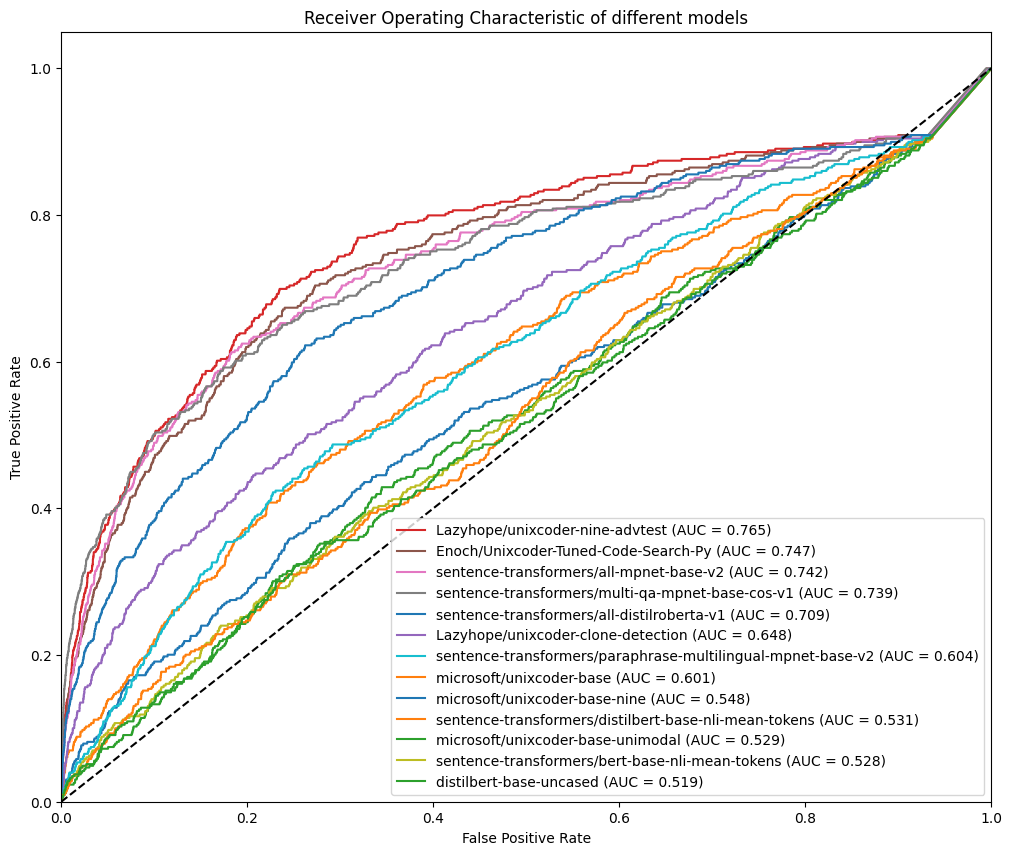

In [14]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

model_auc = {}
y_true = df['topic1'] == df['topic2']
fig = plt.figure(figsize=(12, 10))


def roc(model_name):
    y_score = df[model_name]
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    model_auc[model_name] = roc_auc

    plt.plot(fpr, tpr, label=model_name)


for model in models:
    roc(model)

# Order labels by each model's auc score
handles, labels = plt.gca().get_legend_handles_labels()
order = sorted(range(len(labels)), key=lambda k: -model_auc[labels[k]])
ordered_handles = [handles[idx] for idx in order]
ordered_labels = [f'{labels[idx]} (AUC = {model_auc[labels[idx]]:.3f})' for idx in order]
plt.legend(ordered_handles, ordered_labels, loc="lower right")

plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic of different models')
plt.savefig('roc_readme_evaluation_train_315.eps')
plt.show()

In [15]:
model_auc

{'microsoft/unixcoder-base-nine': 0.5483251976949198,
 'microsoft/unixcoder-base': 0.6013256654549031,
 'microsoft/unixcoder-base-unimodal': 0.5290081795711461,
 'Lazyhope/unixcoder-nine-advtest': 0.765030343539706,
 'Lazyhope/unixcoder-clone-detection': 0.6480414226712109,
 'Enoch/Unixcoder-Tuned-Code-Search-Py': 0.7472810440623439,
 'sentence-transformers/all-mpnet-base-v2': 0.7420360986325985,
 'sentence-transformers/multi-qa-mpnet-base-cos-v1': 0.7392858097178254,
 'sentence-transformers/bert-base-nli-mean-tokens': 0.5281861524977423,
 'sentence-transformers/paraphrase-multilingual-mpnet-base-v2': 0.6040252938429417,
 'sentence-transformers/all-distilroberta-v1': 0.7085937797906957,
 'sentence-transformers/distilbert-base-nli-mean-tokens': 0.5313588898217463,
 'distilbert-base-uncased': 0.5189856920979182}